In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, load_dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
    ShuffleSplit,
)
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas()

from config import RANDOM_SEED

/home/ossamaak0/miniconda3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
dataset = load_dataset("go_emotions", "raw")
dataset.set_format(type="pandas")
df = dataset["train"][:]

## Visualizations

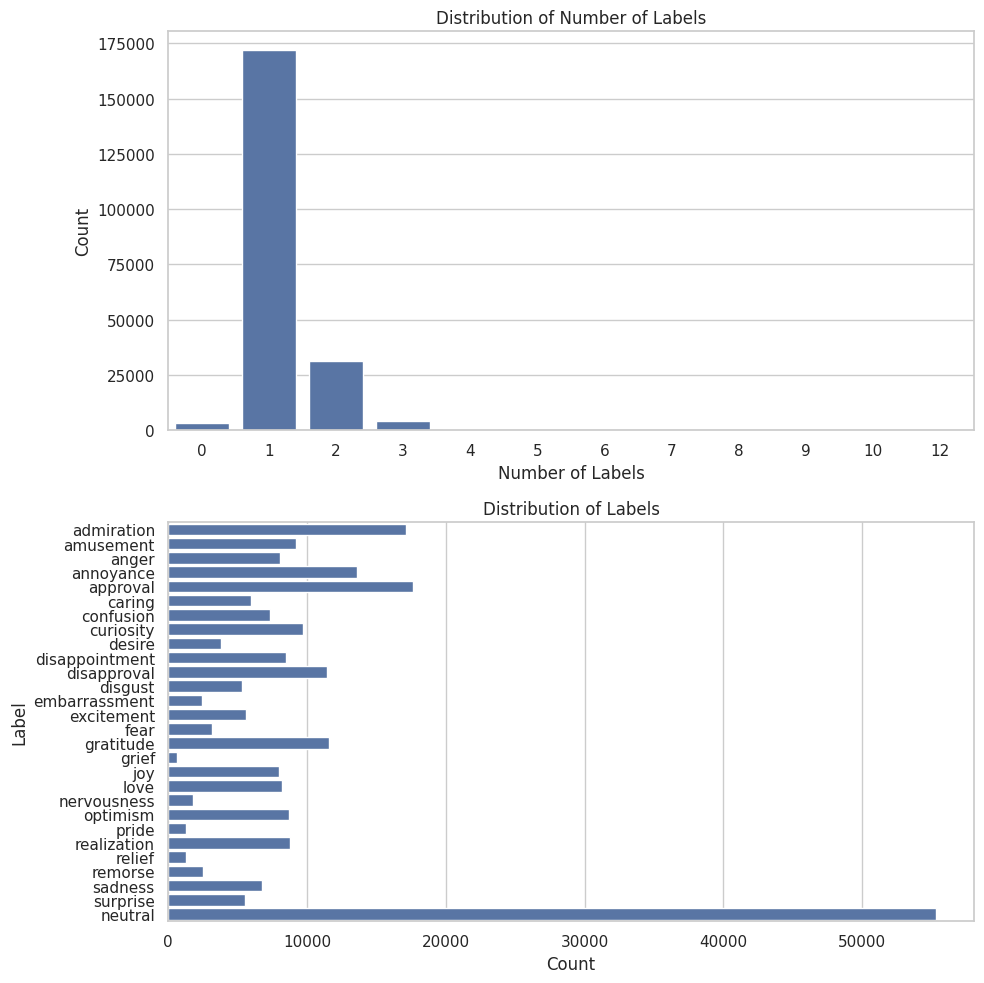

In [3]:
# Count of each label
df["num_labels"] = df.iloc[:, 9:].sum(axis=1)

sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the distribution of number of labels
label_counts = df["num_labels"].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[0])
axs[0].set_title("Distribution of Number of Labels")
axs[0].set_xlabel("Number of Labels")
axs[0].set_ylabel("Count")

# Plotting the distribution of labels
label_counts = df.iloc[:, 9:].sum(axis=0)
label_counts = label_counts.drop("num_labels")
sns.barplot(x=label_counts.values, y=label_counts.index, ax=axs[1])
axs[1].set_title("Distribution of Labels")
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Label")

plt.tight_layout()
plt.show()

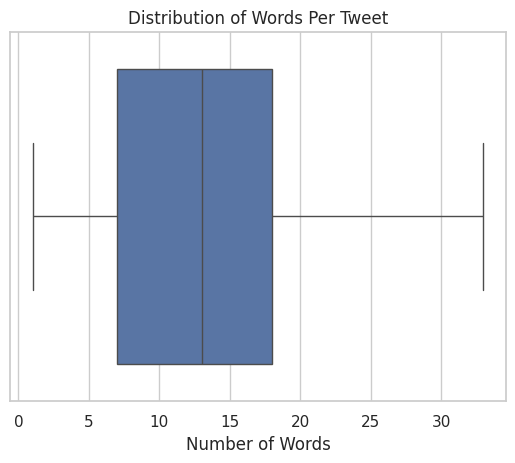

In [4]:
df["Words_Per_Tweet"] = df["text"].apply(lambda x: len(x.split()))

# Creating a boxplot for the number of words in each tweet
fig, ax = plt.subplots()
sns.boxplot(x="Words_Per_Tweet", data=df, ax=ax)

ax.set_title("Distribution of Words Per Tweet")
ax.set_xlabel("Number of Words")
plt.show()

In [5]:
# drop columns (won't be used)
df.drop("num_labels", axis=1, inplace=True)
df.drop("Words_Per_Tweet", axis=1, inplace=True)

## Splitting the data into train and test

In [9]:
# Combining all features into a string for stratification
emotions = df.columns[9:]

df["labels"] = df[emotions].progress_apply(
    lambda row: "".join(str(int(value)) for value in row), axis=1
)

100%|██████████| 211225/211225 [00:01<00:00, 118695.68it/s]


In [10]:
X = df[["text"]]
y = df["labels"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform stratified train-test split
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# split validation set into test and validation
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=RANDOM_SEED
)

/home/ossamaak0/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
# define DFs for train, val and test
train_df = df.iloc[X_train.index].copy()
val_df = df.iloc[X_val.index].copy()
test_df = df.iloc[X_test.index].copy()

train_df["labels"] = train_df["labels"].apply(lambda x: [int(i) for i in x])
val_df["labels"] = val_df["labels"].apply(lambda x: [int(i) for i in x])
test_df["labels"] = test_df["labels"].apply(lambda x: [int(i) for i in x])

In [12]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Model & Tokenizer

In [13]:
model_checkpoint = "distilbert/distilroberta-base"

num_labels = 28
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# define tokenization function
tokenize_function = lambda examples: tokenizer(
    examples["text"], padding="longest", truncation=True
)

# Create HF 🤗 Dataset

In [15]:
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=512)
val_dataset = val_dataset.map(tokenize_function, batched=True, batch_size=512)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=512)

train_dataset = train_dataset.select_columns(["input_ids", "attention_mask", "labels"])
val_dataset = val_dataset.select_columns(["input_ids", "attention_mask", "labels"])
test_dataset = test_dataset.select_columns(["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map: 100%|██████████| 21123/21123 [00:00<00:00, 21714.90 examples/s]


In [17]:
dataset_dict = DatasetDict(
    {"train": train_dataset, "val": val_dataset, "test": test_dataset}
)

In [18]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 168980
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21122
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21123
    })
})

# Trainer

## Training Args

In [22]:
from transformers import Trainer
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    save_total_limit=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
)

## Compute Metrics

We need to fix the `compute metrics` function, maybe by first debugging the error, and possibly fixing it with another function. 

In [23]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    hamming_loss,
    roc_curve,
)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    threshold = 0.5

    preds = (preds > threshold).astype(int)

    precision_micro = precision_score(labels, preds, average="macro", zero_division=0)
    recall_micro = recall_score(labels, preds, average="macro", zero_division=0)
    f1_micro = f1_score(labels, preds, average="macro", zero_division=0)
    accuracy = accuracy_score(labels, preds)

    # Add the expected keys
    metrics = {
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "eval_accuracy": accuracy,  # For Hugging Face Trainer
        "eval_f1": f1_micro,  # For Hugging Face Trainer
    }

    return metrics

## Define the trainer

In [2]:
class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.BCEWithLogitsLoss()
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

NameError: name 'Trainer' is not defined

In [26]:
# trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [1]:
# evaluate the accuray, recall, precision, f1 for per label for the test set

# predict the test set
predictions, labels, _ = trainer.predict(test_dataset)

threshold = 0.5

predictions = (predictions > threshold).astype(int)

# calculate the metrics for each label
precision = precision_score(labels, predictions, average=None)
recall = recall_score(labels, predictions, average=None)
f1 = f1_score(labels, predictions, average=None)
accuracy = accuracy_score(labels, predictions)

# create a DataFrame to display the metrics
metrics_df = pd.DataFrame(
    {"Label": emotions, "Precision": precision, "Recall": recall, "F1": f1}
)

print(metrics_df)

NameError: name 'trainer' is not defined

In [ ]:
# get a multi-label prediction
def predict(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    logits = output.logits

    # apply sigmoid
    probs = torch.sigmoid(logits)
    probs = probs.detach().numpy()

    # threshold at 0.5 to get the predicted labels
    threshold = 0.5
    predicted_labels = np.where(probs > threshold, 1, 0)
    predicted_labels = predicted_labels[0]

    # get it's location in the binary columns
    predicted_labels = np.where(predicted_labels == 1)[0]

    return predicted_labels


# predict a sample
text = "I am so happy today!"
predicted_labels = predict(text)
print(predicted_labels)

In [23]:
# check if the sum of numbers between column 9 and 37 is greater than two, if so return the sample
def get_sample_with_multiple_labels(df):
    for i in range(len(df)):
        if df.iloc[i, 9:37].sum() > 1:
            return df.iloc[i, 0], i


sample, i = get_sample_with_multiple_labels(train_df)
print(sample)
print(i)

That is odd.
9


In [24]:
train_df.iloc[i, 9:37]

admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    1
disapproval       0
disgust           1
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
Name: 9, dtype: object